# Simulación en python de la resolución del problema 3COL en el modelo no restringido de Adleman

### Máster universitario en lógica computación e inteligencia artificial
### Computación bio-inspirada

__Autor:__ Arturo Pérez Sánchez

En este notebook se realizará una simulación de la resolución del problema 3COL en el modelo no restringido de Adleman, para ello, comenzaremos importando e instalando si fuera necesario las librerias, cabe destacar que se ha intentado utilizar en la medida de lo posible el menor número de librerias posibles para facilitar la ejecución a los usuarios.

In [1]:
# !pip install networkx
from itertools import product   
import networkx as nx
import matplotlib.pyplot as plt
import random
import string
import math
import time

Una vez importadas las dependencias, comenzaremos definiendo los parámetros que vamos a utilizar tanto para generar el grafo como para generar las coloraciones.
<ul>
    <li> <b>n: </b> Se trata del número de nodos que tendrá nuestro grafo, aqui tenemos que destacar dos factores, el primero es que la complejidad de la generación de posibles coloraciones es de caracter exponencial (concretamente 3 elevado a n), por lo que no es recomendable introducir valores muy altos, y el segundo factor es que tenemos que tener cuidado si introducimos las aristas manualmente para no generar aristas que apunten a nodos inexistentes</li>
    <li> <b>colores: </b> Se trata de un array con los códigos en hexadecimal de los colores que vamos a utilizar, como estamos trabajando con el problema 3COL introducimos 3 colores, aunque la adaptación del código para resolver el problema con otro número de colores es trivial</li>
    <li><b>densidad: </b> Esta es la probabilidad (entre 0 y 1) de que se generen aristas adicionales a cada nodo, de manera que si toma el valor 0 los nodos solo estarán conectados con el consecutivo y si toma el valor 1 todos los nodos estarán conectados entre sí, es decir, generaráimos un grafo completo. (Si introducimos las aristas de manera manual este parámetro no tiene utilidad)</li>
    

In [2]:
n = 6
colores = ['#F8CECC', '#FFF2CC', '#DAE8FC']
densidad = 0.55

A continuación definiremos el método <i>generaAristas()</i> donde a partir de la densidad y el número de nodos se generaran las aristas de nuestro grafo, si vamos a introducir las aristas a mano no hace falta ejecutar esta función.<br>
De esta función es importante resaltar que la generación de aristas es tal que para cada par de nodos, el nodo inferior siempre estará en la primera posición y el mayor en la segunda, por ejemplo: una arista válida entre los nodos 2 y 3 sería (2, 3), en cambio, el par (3, 2) no sería una arista válida. Esto tambien tendremos que tenerlo en cuenta si introducimos las aristas de forma manual

In [3]:
def generaAristas(nNodos):
    res = [] #Aqui iremos guardando las aristas
    for i in range(1, nNodos): #recorremos todos los nodos
        res.append([i-1,i]) #cada nodo va a estar conectado al menos con su consecuente (para evitar nodos aislados)
        rand = random.random()
        available = list(range(i-1)) #lista de nodos con los que el nodo i puede unirse
        while (rand < densidad and available): #probabilidad de que se genere una nueva arista
            selected = random.choice(available)
            res.append([selected, i]) #primero ponemos selected porque es el nodo inferior
            available.remove(selected)
            if (not available): #si no quedan aristas con las que unirse nos salimos del bucle
                break
            rand = random.random()
            
    return sorted(res,key=lambda x: x[0]) #Antes de devolver la lista de aristas las ordenamos

Con este método definido ya podemos generar la instancia del grafo que vamos a resolver, para ello, utilizaremos la librería networkx, es tan sencillo como llamar a la función <i>graph</i> (por defecto es un grafo no dirigido, por lo que no tenemos que añadir ningún parámetro), generar las aristas (bien de manera manual o bien utilizando la función creada anteriormente) y añadirlas al grafo mediante el método <i>add_edges_from()</i>.

In [4]:
# Generación manual (útil para resolver instancias concretas)
# aristas = [[0, 1], [0, 2], [0, 4], [1, 2], [2, 3], [3, 4]]

# Generación automática
aristas = generaAristas(n)
G=nx.Graph() #Creamos el grafo
G.add_nodes_from(range(n)) #Indicamos los nodos
G.add_edges_from(aristas) #añadimos todas las aristas


Con esto ya podríamos dibujar el grafo, sin embargo, como no hemos especificado ni que etiqueta ni la posición que tiene cada nodo, por lo que cuando lo mostremos no vamos a saber que nodo es cada uno, y la posición de los nodos irá cambiando cada vez que mostremos el grafo.<br>
Es por ello que vamos a definir el diccionario labels, donde asignaremos un número a cada nodo y el parámetro pos, donde, utilizando una vez más la librería netwrokx fijaremos la posición de cada nodo.<br>
Con esto, ya podemos graficar la instancia del grafo que vamos a resolver, para ello basta con llamar a la función <i>draw()</i>. (Para una mejor visualización tambien especificaremos el tamaño de los nodos y la fuente)

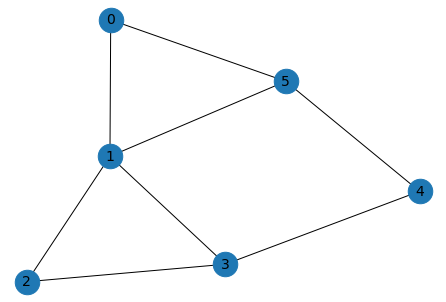

In [5]:
labels={} #lista de etiquetas que nos servirá para enumerar los nodos
for i in range(len(G)): #recorremos todos los nodos
    labels[i]= str(i) #le asignamos su propio indice como etiquetas para que aparezca enumerado cuando lo grafiquemos

#Posiciones de los nodos
pos=nx.spring_layout(G)

nx.draw(G, pos, labels=labels, node_size=600, font_size=14, font_weight=500)

Una vez definida la intancia del grafo que vamos a resolver, podemos comenzar con la simulación del modelo de computación, pero antes es conveniente repasar el pseudocódigo para ir referenciandolo a medida que vamos implementando las funciones:<br>
<img src="pseudoCodigo.PNG" alt="Pseudocódigo" style="width: 300px;"/><br>
Como se puede observar, durante el modelo se realizan 4 operaciones básicas:
<ul>
    <li><b>Amplificar </b>(lineas 3 y 4) A partir de un tubo T creamos dos copias de este</li>
    <li><b>Extraer </b>(lineas 6 y 8): En esta función partimos de un tubo T y una cadena γ y lo que se hace es separar los conjuntos del tubo T en dos tubos, uno con los elementos que continenen a la cadena γ (en el pseudocodigo denotado como +(T, γ)) y otro con los que no (denotado como -(T, γ)) </li>
    <li><b>Mezclar </b>(lineas 9 y 10): Esta función se encarga de combinar dos tubos en un único tubo</li>
    <li><b>Detecar </b>(linea 11) dado un tubo T, la operación detectar devolverá SI cuando T contenga alguna molécula y NO en caso contrario</li>
    </ul>

Aunque la creación de estas funciones en python no es necesaria, debido a que son en su mayoría muy simples, hemos decidido implementarlas para que quede explicito que operación a nivel molecular se está simulando en cada caso.<br>
Es importante señalar que en la simulación codificaremos las moléculas como una lista de tamaño N con colores, de manera que estaría indicando que el nodo n-esimo está coloreado con el color de la posición n. Los tubos en cambio, serán codificados como una lista de listas de manera que cada tubo contendrá una serie de moleculas (que a su vez está codificando una posible coloración del grafo).

## Generación del tubo T<sub>0</sub>
El primer paso que tenemos que realizar para realizar el experimento es la generación del tubo inicial T<sub>0</sub> con todas las coloraciones posibles del grafo. Para ello, crearemos la función <i>todasColoraciones()</i> que a partir de los colores y el número de nodos que hemos especificado como parámetros generará todas las coloraciones posibles de ese grafo. <br> 
Este método es crítico, ya que si introducimos un número de nodos excesivo puede generar un tubo de tamaño intratable, esto es por el caracter exponencial anteriormente mencionado.


In [6]:
def todasColoraciones(nNodos):
    results = []
    for c in product(colores, repeat = nNodos):
        results.append(c)
    return results

In [7]:
t0 = todasColoraciones(n)
print(f'existen {len(t0)} coloraciones posibles para el grafo')

existen 729 coloraciones posibles para el grafo


Una vez generado el tubo, podemos mostrar algunas (con grafos muy pequeños podriamos mostrarlas todas) de sus instancias para verificar que efectivamente contiene moleculas que codifican posibles coloraciones del grafo, para ello repetimos el proceso anterior pero al llamar a la función <i>draw()</i> especificaremos tambien la coloración mediante la propiedad __node_color__, donde iremos indicando diferentes coloraciones por cada figura

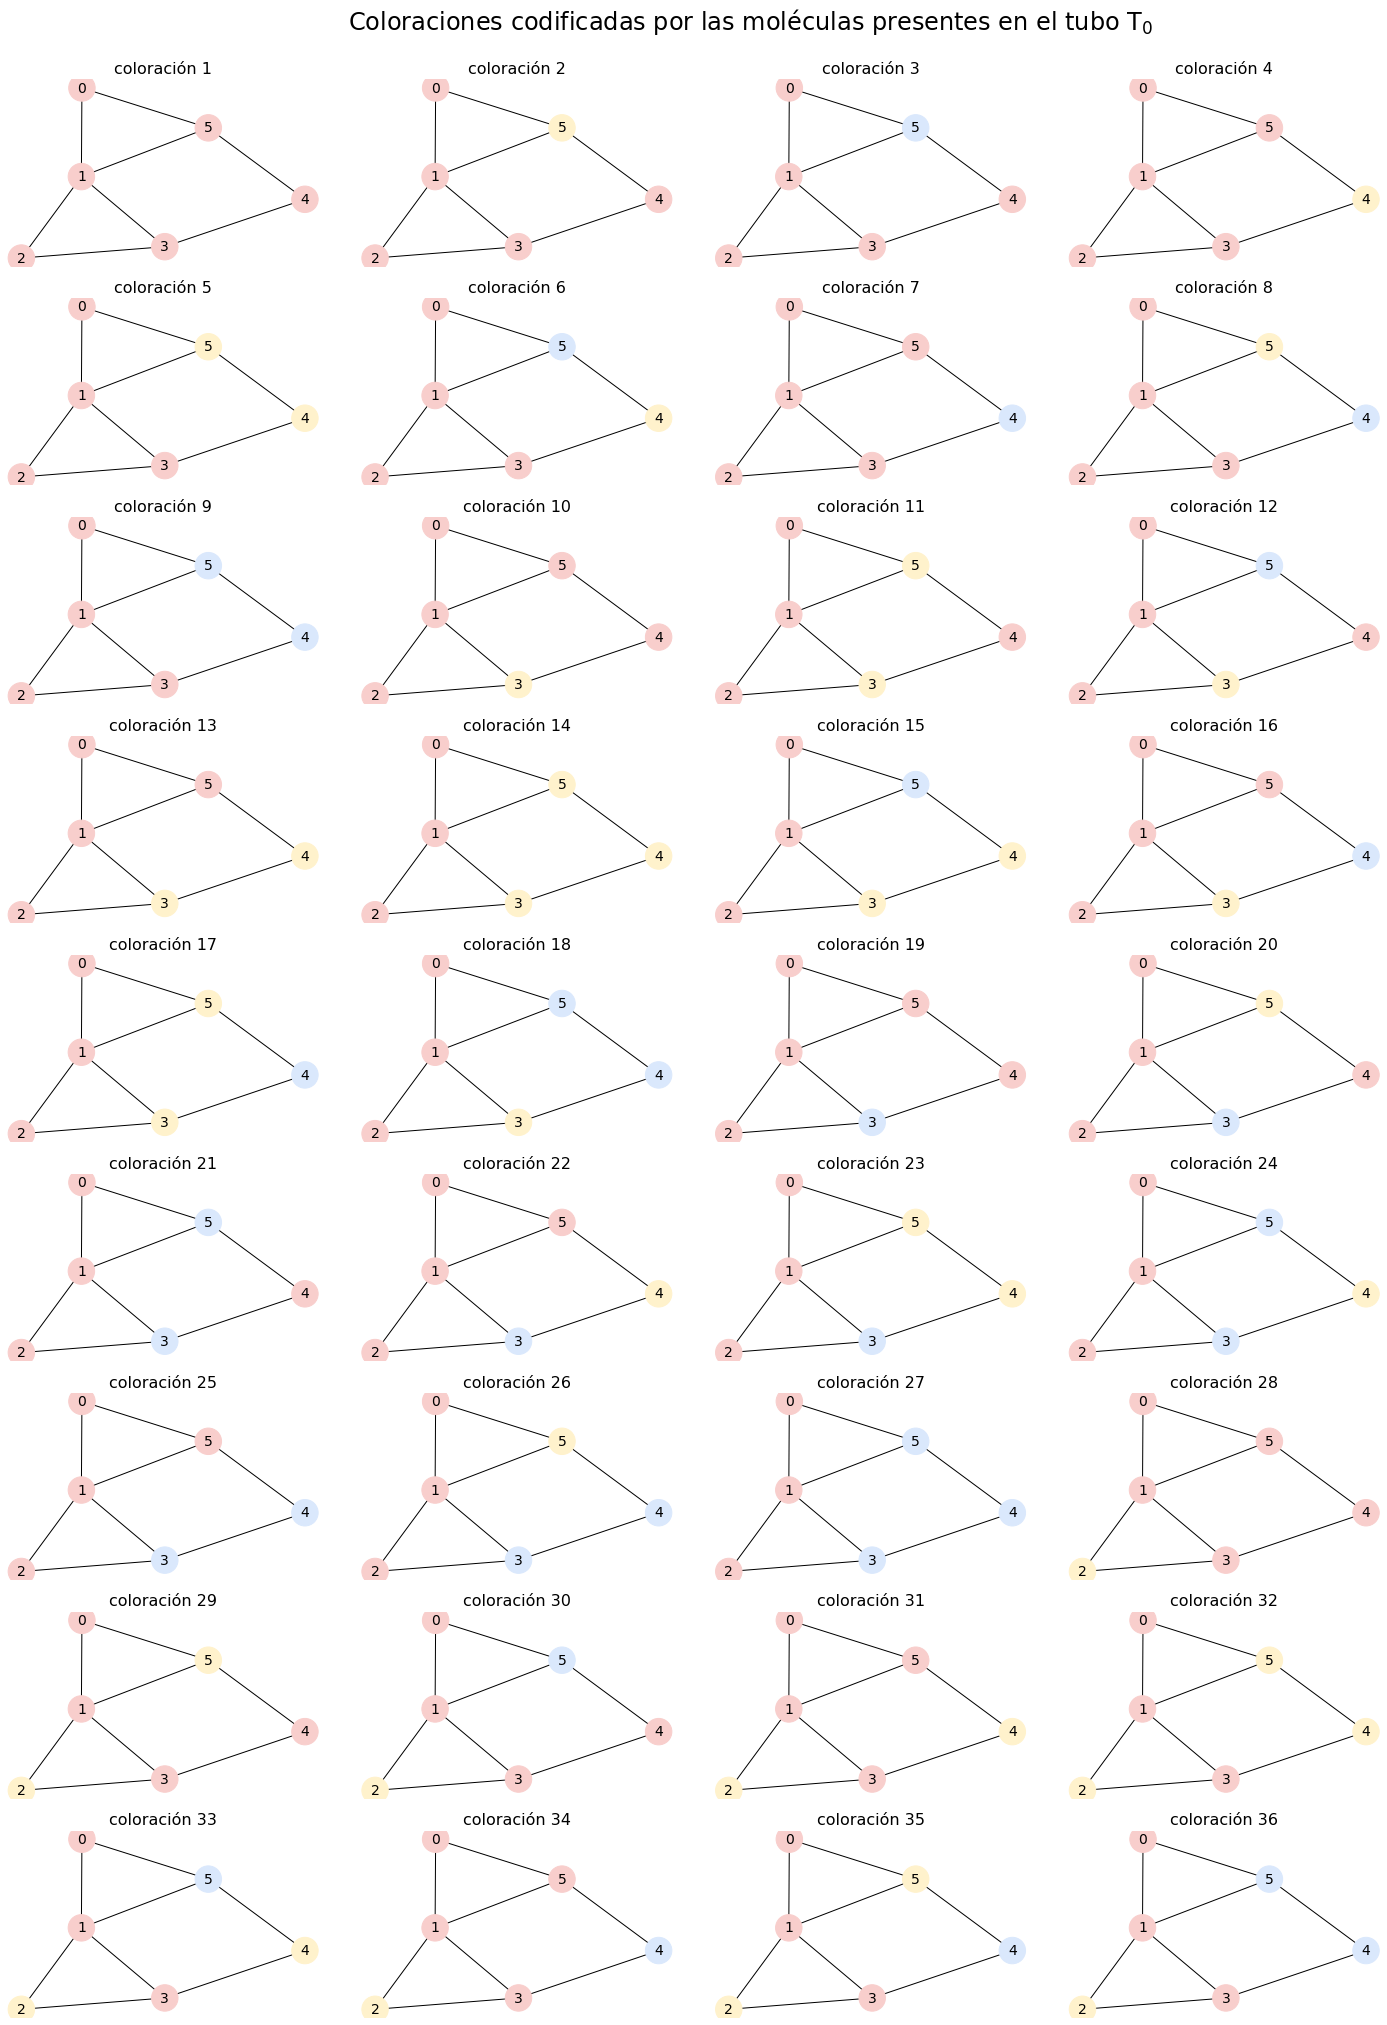

In [8]:
#número de grafos que vamos a mostrar
plots = min(36, len(t0))

#Número de columnas (4), filas (máximo 9) y tamaño de cada figura (20x30)
fig, axes = plt.subplots(min(9, math.ceil((len(t0)+1)/4)),4,figsize=(18,24))
ax = axes.flatten()

# Mostramos las primeras instancias de t0
fig.suptitle(r'Coloraciones codificadas por las moléculas presentes en el tubo T$_0$', fontsize=24)
fig.tight_layout(rect=[-0.1, -0.2, 1, 0.97])
for i in range(plots):
    ax[i].set_title(f'coloración {i+1}', fontsize=16)
    nx.draw_networkx(G, pos, node_color=t0[i] , labels = labels, node_size=700, font_size=14, font_weight=500, ax=ax[i])
    ax[i].set_axis_off()

Una vez generado el tubo T<sub>0</sub> podemos comenzar con la ejecución del modelo, pero como habiamos comentado anteriormente, primero crearemos 4 funciones para representar las 4 operaciones básicas necesarias.

In [9]:
# Si el tubo está vacio devuelve NO, si el tubo tiene moléculas devuelve SI
def detectar(t):
    if (not t):
        return 'NO'
    else:
        return 'SI'

In [10]:
# Combina dos tubos
def mezclar(t1, t2):
    return t1+t2

In [11]:
# Crea dos copias del tubo
def amplificar(t):
    return t, t

In [12]:
# En nuestro contexto la cadena c se compone por un par de valores, el primer valor es un nodo y el segundo un color
# El conjunto positivo son las moleculas de t que continen la cadena c, es decir, que que codifican el color c[1] al nodo c[0]
# El conjunto negativo son las moleculas de t que no continen la cadena c
def extraer(t, c):
    positivo = []
    negativo = []
    for i in t:
        if (i[c[0]] == c[1]):
            positivo.append(i)
        else:
            negativo.append(i)
    return positivo, negativo

Ahora ya lo tenemos todo listo para empezar con la ejecución del programa, con las operaciones definidas y el tubo preparado, veremos que diseñar el modelo es relativamente sencillo.

In [24]:
# Recibe como entrada un tubo lleno de moleculas que codifican todas las posibles cooloraciones del grafo
def modelo(t0, nNodos, aristas):
    for i in range(nNodos - 1): #Bucle principal, recorriendo los nodos
        taux, t1 = amplificar(t0)
        t2, t3 = amplificar(taux)
        T = [t1,t2,t3] #Guardamos los tubos en una lista para poder referirnos a ellos por sus indices
        # En el pseudocodigo el bucle itera desde 1 hasta 3, pero como en python
        # los indices de las listas empizan por 0 iteraremos de 0 a 2, el resultado es el mismo.
        for j in range(len(colores)): #Es de esperar que sean 3 colores, pero puesto de esta forma se puede generalizar más
            T[j], __ = extraer(T[j], (i, colores[j]))#filtramos quedandonos con las moléculas que codifican el color j al nodo i
            sub = [ar for ar in aristas if ar[0] == i] #aristas con extremo inferior i 
            for l in sub:
                __, T[j] = extraer(T[j], (l[1], colores[j])) # Nos quedamos con las coloraciones validas del subgrafo inducido
                
        t0 = mezclar(T[0], T[1]) #volvemos a combinar todos los tubos
        t0 = mezclar(t0, T[2])

    # Además de devolver si existe solución devolveremos tambien el tubo final para visualizar las soluciones si las hubiera
    return detectar(t0), t0 

Llegados a este punto, solo tenemos que ejecutar el modelo para comprobar que funciona correctamente

In [26]:
salida, tubo = modelo(t0, n, aristas)
print (f"el grafo {salida} tiene solución")

el grafo SI tiene solución


Como el modelo nos informa que el grafo SI tiene solución, sabemos que el tubo de salida tiene al menos una molécula y que todas ellas codifican coloraciones válidas para nuestro grafo. <br> Como para nuestro grafo en cuestión no hay excesivas coloraciones válidas, podemos recorrer todas las moleculas del tubo de salida y ver que coloración codifica cada una, la manera de hacer esto en python es la misma que cuando mostramos todas las coloraciones que habian en el tubo de entrada 

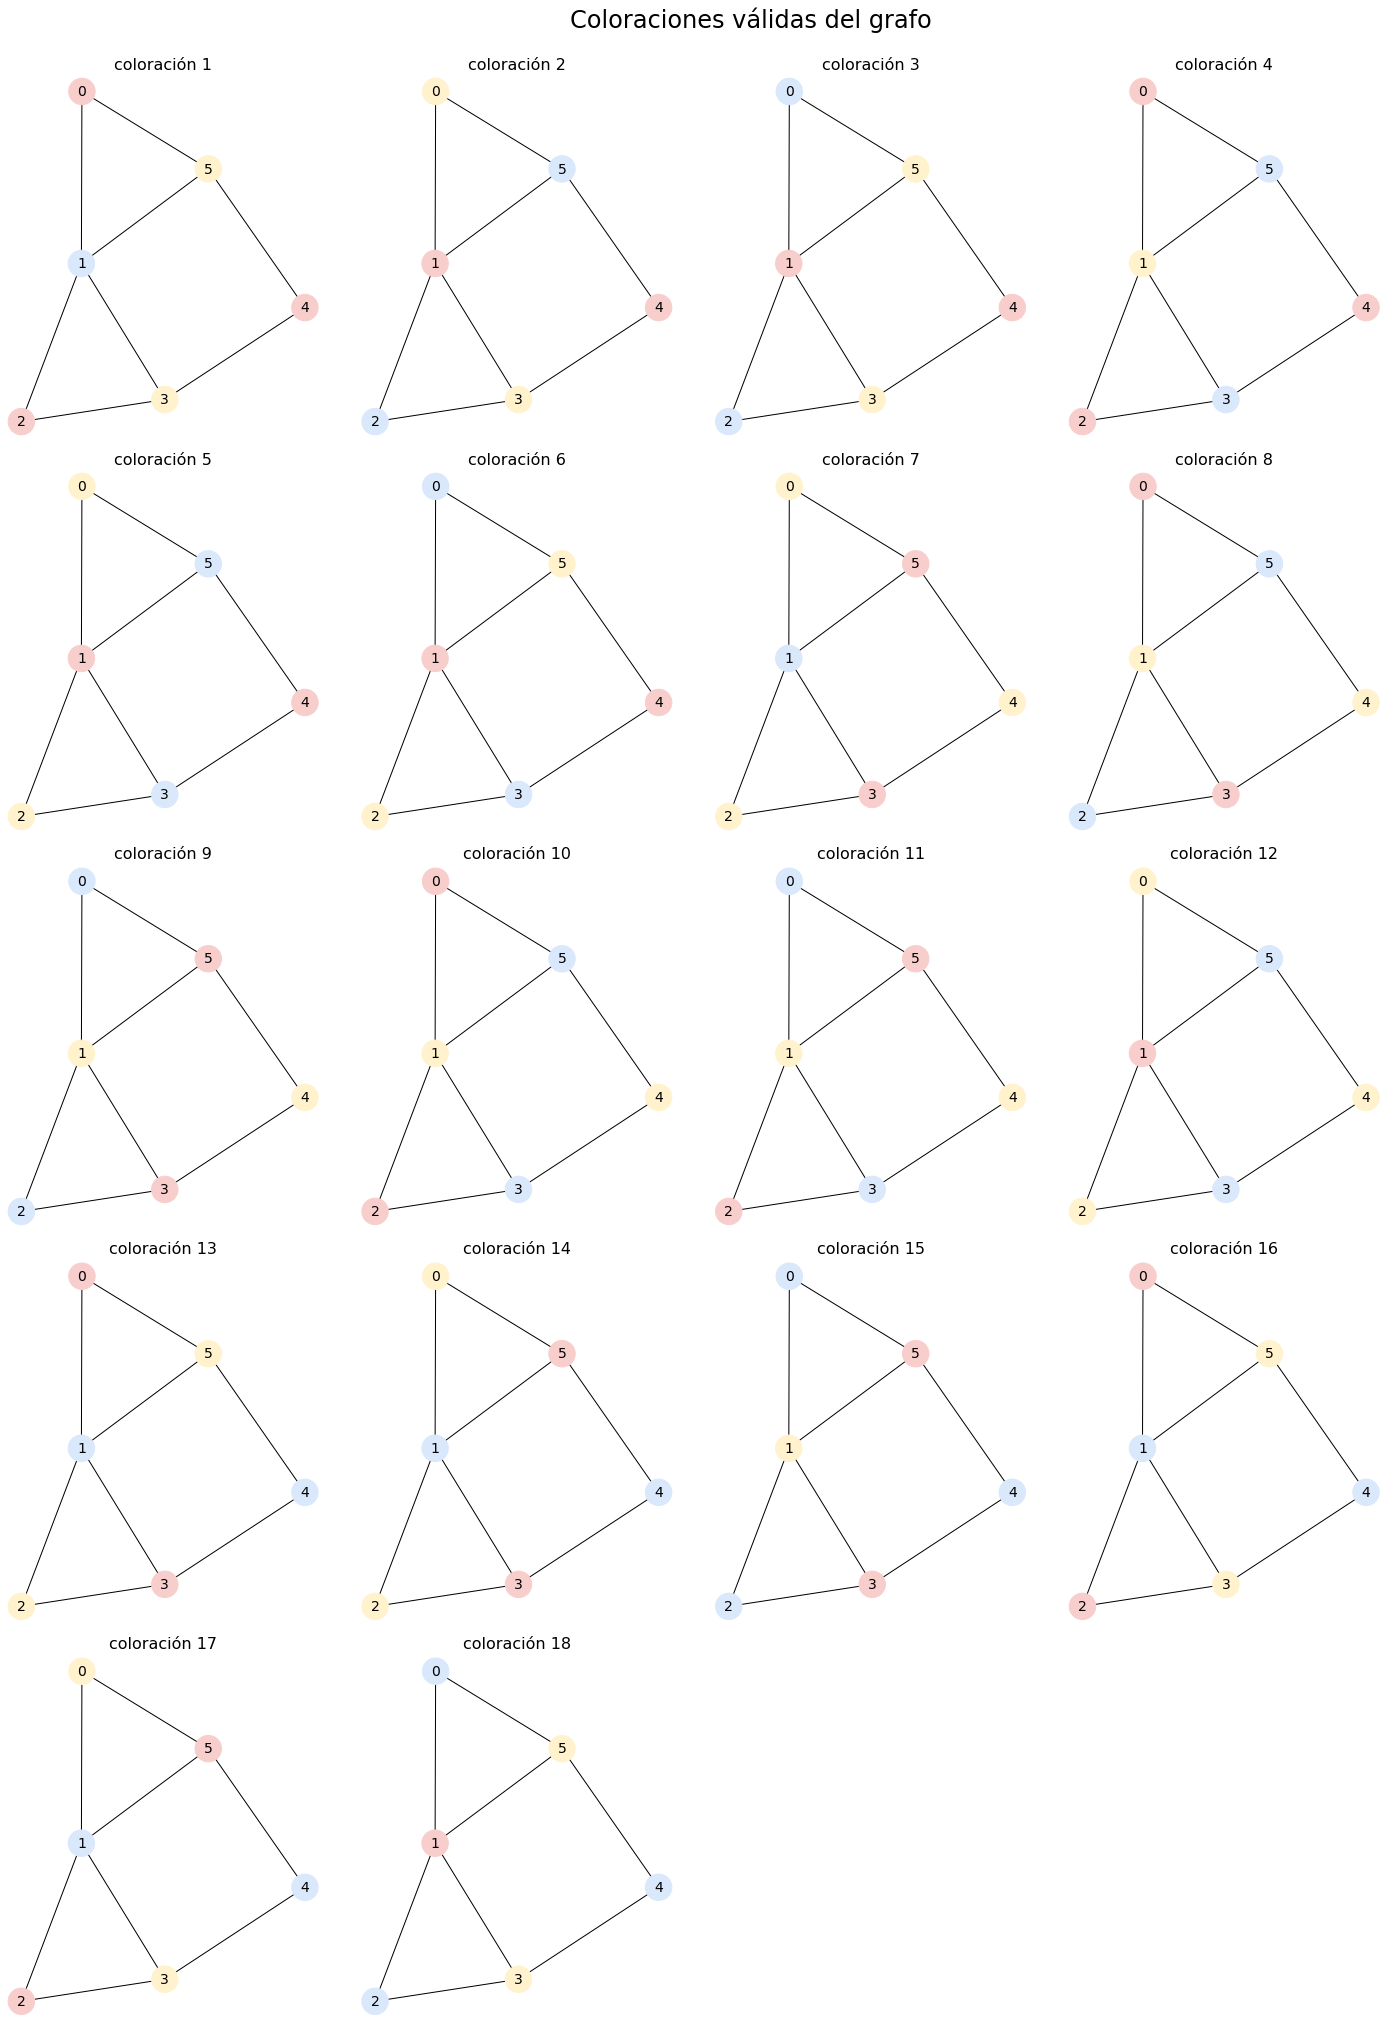

In [27]:
#número de grafos que vamos a mostrar
plots = min(36, len(tubo))

#Número de columnas (4), filas (máximo 9) y tamaño de cada figura (20x30)
fig, axes = plt.subplots(min(9, math.ceil((len(tubo)+1)/4)),4,figsize=(18,24))
ax = axes.flatten()

# Mostramos las primeras instancias de t0
fig.suptitle(r'Coloraciones válidas del grafo', fontsize=24)
fig.tight_layout(rect=[-0.1, -0.2, 1, 0.97])
for i in range(plots):
    ax[i].set_title(f'coloración {i+1}', fontsize=16)
    nx.draw_networkx(G, pos, node_color=tubo[i] , labels = labels, node_size=700, font_size=14, font_weight=500, ax=ax[i])

#Eliminamos los ejes de coordenadas para una mejor visualización
for i in ax:
    i.set_axis_off()

Como se puede observar, se han encontrado 18 coloraciones válidas para esta instancia del problema 3COL. Por último, vamos a realizar un pequeño análisis del rendimiento de nuestro modelo, para ello importaremos la libreria pandas y la utilizaremos para crear un dataframe donde iremos guardando las diferentes ejecuciones de nuestro modelo.<br>
Además, para facilitar el proceso, tambien crearemos una función <i>experimento</i> donde se ejecutará tanto la generación automática del grafo como el modelo.

In [74]:
def experimento(nodos): # Número de nodos
    inicio = time.time() #Para contar el tiempo de ejecución
    #Generación del grafo
    aristas = generaAristas(nodos)
    G=nx.Graph() #Creamos el grafo
    G.add_nodes_from(range(nodos)) #Indicamos los nodos
    G.add_edges_from(aristas) #añadimos todas las aristas
    
    #Generación del tubo inicial T0
    t0 = todasColoraciones(nodos)
    
    #ejecución del modelo
    salida, tubo = modelo(t0, nodos, aristas)
    
    #Cálculo del tiempo de ejecución
    tiempo = time.time() - inicio
    return G, salida, tubo, tiempo

In [79]:
import pandas as pd

soluciones = []

#generamos el dataframe
RESULTADOS = pd.DataFrame(columns=['Tiene Solución', 'nº soluciones', 'Tiempo de ejecución'])

#Ejecutamos el experimento con grafos desde tamaño 5 hasta 16
# WARNING: Tarda aproximandamente 1 minuto y medio
for i in range (5, 17):
    grafo, salida, tubo, tiempo = experimento(i)
    if(salida == 'SI'):
        soluciones.append((grafo, tubo[0]))
    RESULTADOS.loc[f'{i} nodos'] = salida, len(tubo), tiempo
    
#mostramos los resultados
RESULTADOS

,Tiene Solución,nº soluciones,Tiempo de ejecución
5 nodos,SI,48,0.000000
6 nodos,NO,0,0.001999
7 nodos,NO,0,0.003999
8 nodos,SI,126,0.011997
9 nodos,NO,0,0.027997
10 nodos,NO,0,0.088001
11 nodos,SI,228,0.339000
12 nodos,SI,18,0.833004
13 nodos,NO,0,2.639995
14 nodos,SI,96,8.632001


Como era de esperar, el tiempo de ejecución se triplica cada vez que añadimos un nuevo nodo.<br>
Por último, a modo de curiosidad podemos mostrar la primera solución encontrada de cada grafo

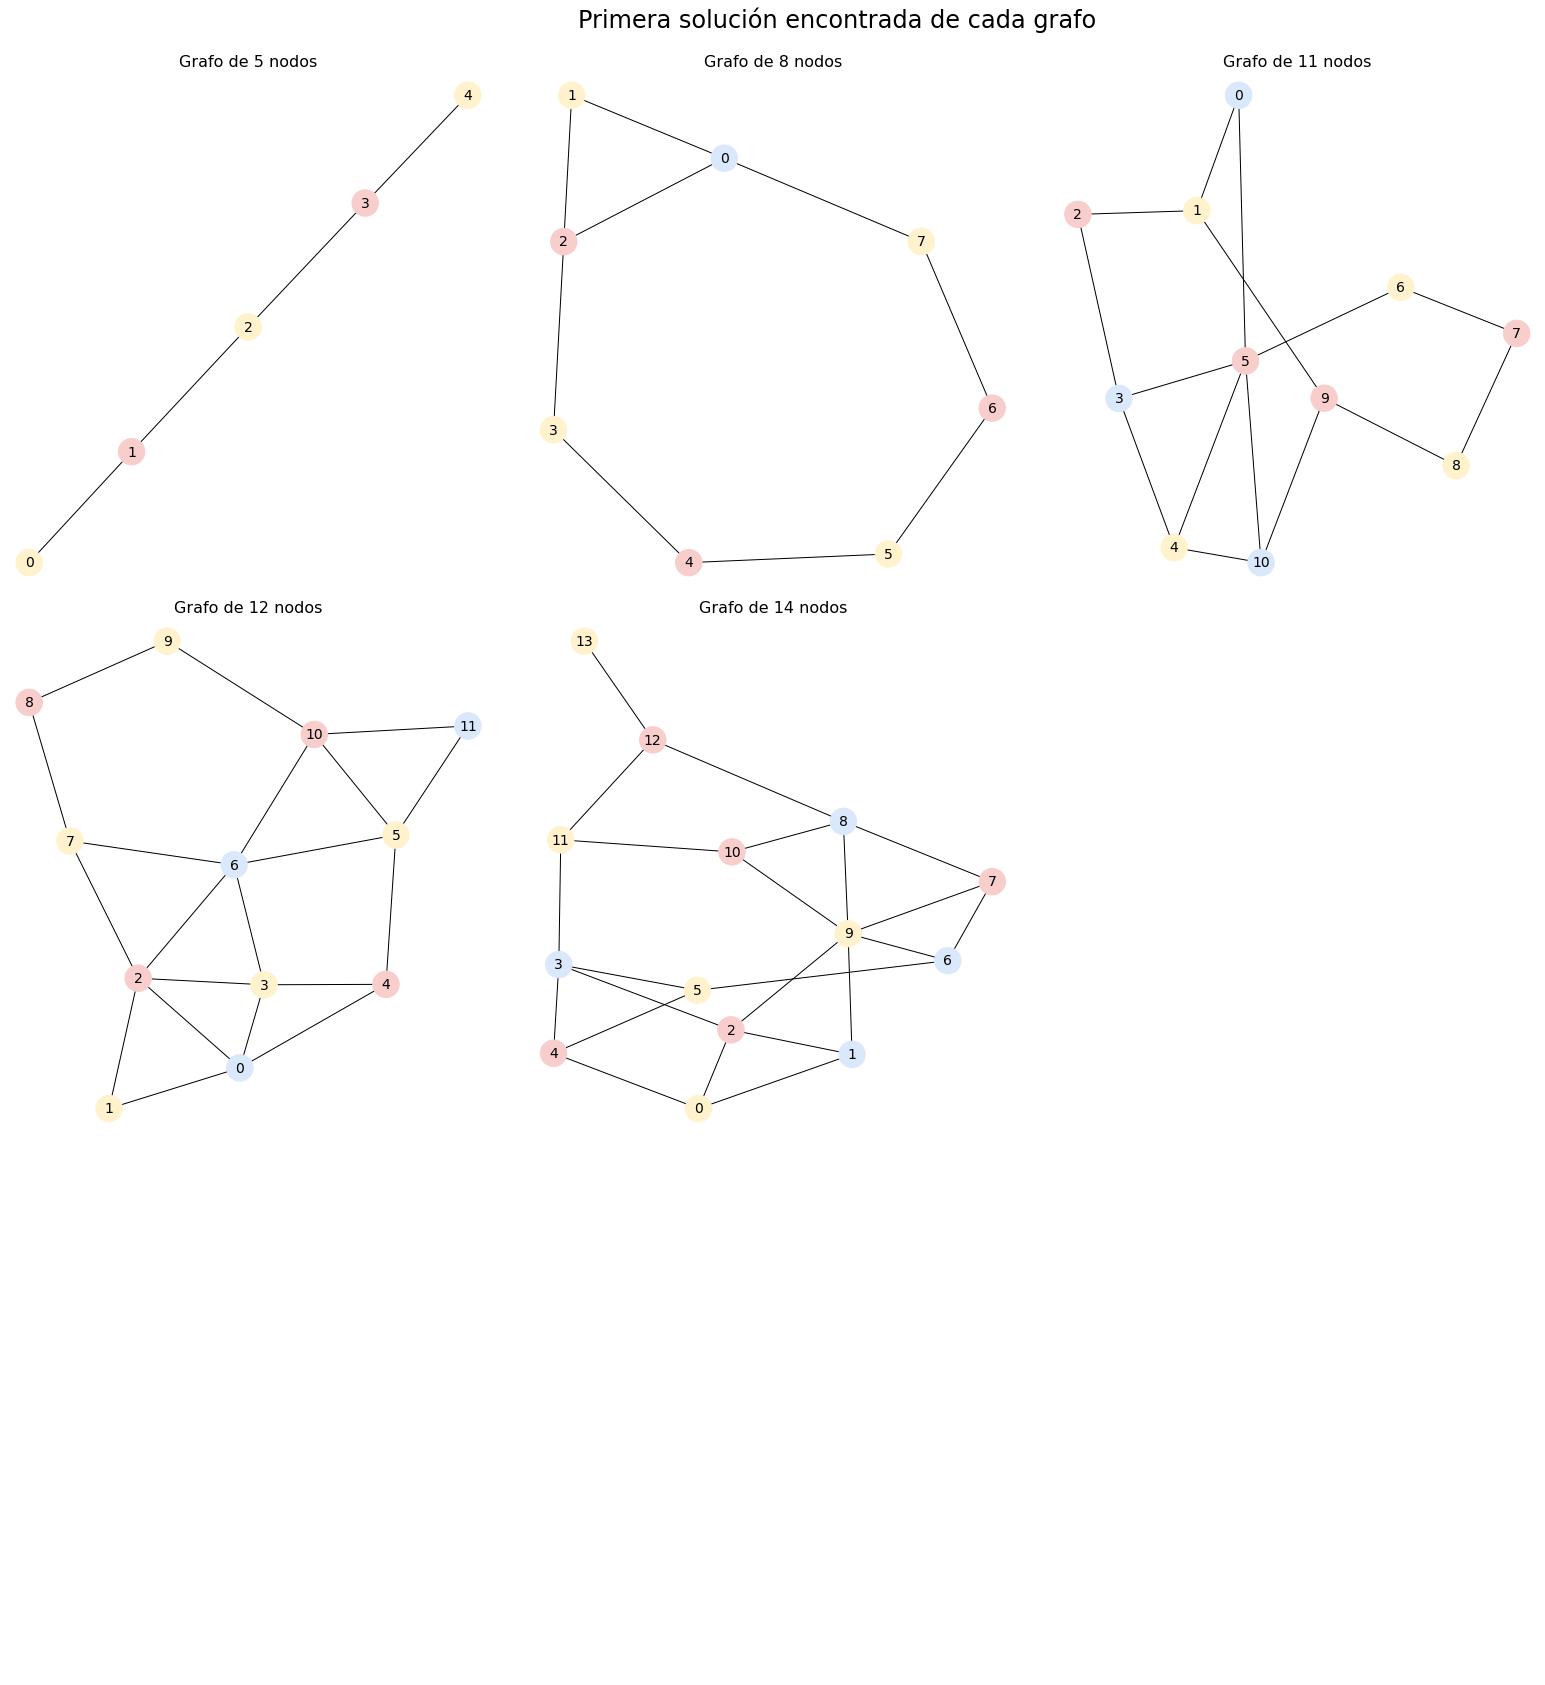

In [82]:
#número de grafos que vamos a mostrar
plots = len(soluciones)

#Número de columnas (3), filas (máximo 9) y tamaño de cada figura (20x30)
fig, axes = plt.subplots(3,3,figsize=(20,20))
ax = axes.flatten()

# Mostramos las primeras instancias de t0
fig.suptitle(r'Primera solución encontrada de cada grafo', fontsize=24)
fig.tight_layout(rect=[-0.1, -0.2, 1, 0.97])
for i in range(plots):
    G = soluciones[i][0]
    
    labels={} #lista de etiquetas que nos servirá para enumerar los nodos
    for j in range(len(G)): #recorremos todos los nodos
        labels[j]= str(j) #le asignamos su propio indice como etiquetas para que aparezca enumerado cuando lo grafiquemos
        
    #Posiciones de los nodos
    pos=nx.spring_layout(G)
    
    ax[i].set_title(f'Grafo de {len(soluciones[i][1])} nodos', fontsize=16)
    nx.draw_networkx(G, pos, node_color=soluciones[i][1], labels=labels, node_size=700, font_size=14, font_weight=500, ax=ax[i])

#Eliminamos los ejes de coordenadas para una mejor visualización
for i in ax:
    i.set_axis_off()